In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
main_path = os.getcwd()
wealth0 = 10000

# 2 yr performance result for KCA model with param q=1e-7
df0 = pd.read_pickle('bear_performance_result_2y0.pkl')
# 2 yr performance result for KCA model with param q=1e-6
df1 = pd.read_pickle('bear_performance_result_2y1.pkl')
# 2 yr performance result for KCA model with param q=1e-5
df2 = pd.read_pickle('bear_performance_result_2y2.pkl')

# Concatenate cumulative wealth from each different model to 'df'
df = pd.concat([df0["benchmark_wealth"], df0["portfolio_wealth"], df1["portfolio_wealth"], df2["portfolio_wealth"]], axis=1, keys=['benchmark','df0','df1','df2'])
df.head(2)

,benchmark,df0,df1,df2
0,10000.000000,10000.000000,10000.000000,10000.00000
1,9910.671814,10045.705553,9826.967256,10208.20844


In [2]:
df0.head(2)

,day,benchmark_wealth,bench_risky,portfolio_wealth,port_risky,pred_km
0,104,10000.000000,"[0.14285714285714285, 0.14285714285714285, 0.1...",10000.000000,"[0.14285714285714285, 0.14285714285714285, 0.1...",NaN
1,105,9654.349413,"[0.17702558020697656, 0.17276905572304072, 0.1...",11065.203082,"[1.1600425363199747, 0.15074020344216096, -0.1...","[0.005343068306549565, -0.010638521311625952, ..."


In [12]:
# load asset return
df_r = pd.read_pickle(main_path+'\\data\\future_return_bear.pkl')
df_r = df_r.fillna(method='ffill').dropna()

incept = 105
t = df_r.index[incept:incept+52*2+1]
t

DatetimeIndex(['2013-01-28', '2013-02-07', '2013-02-12', '2013-02-22',
               '2013-02-27', '2013-03-04', '2013-03-14', '2013-03-19',
               '2013-04-03', '2013-04-08',
               ...
               '2014-12-19', '2014-12-24', '2014-12-29', '2015-01-08',
               '2015-01-13', '2015-01-23', '2015-01-28', '2015-02-02',
               '2015-02-12', '2015-02-17'],
              dtype='datetime64[ns]', name='Date', length=105, freq=None)

Calculate max drawdown & sharpe ratio

In [3]:
def calculate_max_drawdown(p:str):
    """
    Arg:
        p: column name in df
    Return:
        j: time index of the beginning of max dradown
        i: time inde of the end of max drawdown
        max_drawdown: $
    """
    drawdown = np.maximum.accumulate(df[p])-df[p]
    max_drawdown = np.max(drawdown)
    i = np.argmax(drawdown) #end of the max drawdown period
    j = np.argmax(df[p][:i]) # start of max drawdown

    return j, i, max_drawdown

def calculate_sharpe(p:str):
    """
    Arg:
        p: column name in df
    Return:
        sharpe1: 1st year sharpe ratio (annualized)
        sharpe2: 2nd year sharpe ratio (annualized)
        sharpe_tot: sharpe ratio over the entire investment period
    """
    week_ret = (df[p] - df[p].shift()) / df[p][:-1]
    yr1_ret, yr2_ret = week_ret[:52], week_ret[52:2*52]

    sharpe1 = np.sqrt(52) * np.mean(yr1_ret)/np.std(yr1_ret)
    sharpe2 = np.sqrt(52) * np.mean(yr2_ret)/np.std(yr2_ret)
    sharpe_tot = np.sqrt(52) * np.mean(week_ret)/np.std(week_ret)
    return sharpe1, sharpe2, sharpe_tot
    

Calculate transaction costs

In [4]:
def calculate_tran_cost(df:object):
    """calcualte transaction cost at each time step
    Arg:
        df: Dataframe object that consists weight of each asset (i.e. df0['bench_risky'])
    Return:
        trans_cost: list of transactions cost over the investment period
    """
    n = df.shape[0]
    trans_cost = []
    for row in range(1,n):
        trans_cost.append(abs(df.diff())[row].sum()*0.005)

    return trans_cost

In [5]:
data={'portfolio':[], 'period':[], 'max_drawdown':[], 'sharpe_yr1': [], 'sharpe_yr2': [], 'overall_sharpe':[]}
trans_data={}
for p in ['benchmark','df0', 'df1', 'df2']: #loop through each portfolio in df
    j, i, max_down = calculate_max_drawdown(p)
    sharpe_yr1, sharpe_yr2, sharpe_tot = calculate_sharpe(p)

    data['sharpe_yr1'].append(sharpe_yr1)
    data['sharpe_yr2'].append(sharpe_yr2)
    data['overall_sharpe'].append(sharpe_tot)
    data['portfolio'].append(p)
    data['period'].append((j,i))
    data['max_drawdown'].append(max_down)

# loop thru risky asset weights
for i, ele in enumerate([df0['bench_risky'], df0['port_risky'], df1['port_risky'], df2['port_risky']]):
    trans_data[str(i)+ele.name] = calculate_tran_cost(ele)

plot cumulative performance

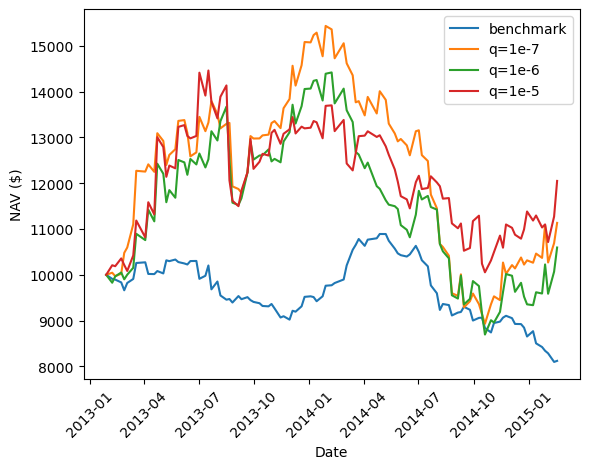

In [13]:
plt.plot(t, df[['benchmark','df0', 'df1', 'df2']], label=['benchmark', 'q=1e-7', 'q=1e-6', 'q=1e-5'])
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('NAV ($)')
plt.show()

In [7]:
res = pd.DataFrame(data=data)
res

,portfolio,period,max_drawdown,sharpe_yr1,sharpe_yr2,overall_sharpe
0,benchmark,"(62, 103)",2792.618173,-0.271521,-1.688962,-0.982074
1,df0,"(51, 87)",6501.787387,1.714370,-1.591716,0.008291
2,df1,"(52, 87)",5721.736944,1.329987,-1.563503,-0.114460
3,df2,"(23, 87)",4404.921953,0.841706,-1.005421,0.084044


plot transaction costs for each portfolio

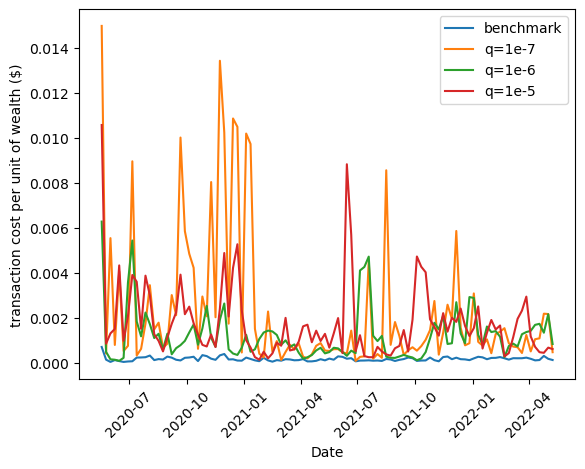

In [8]:
res_cost = pd.DataFrame(trans_data)
res_cost.columns = ['benchmark','df0', 'df1', 'df2']
plt.plot(t[1:], res_cost, label=['benchmark', 'q=1e-7', 'q=1e-6', 'q=1e-5'])
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('transaction cost per unit of wealth ($)')
plt.show()

Plot NAV with transaction costs for each portfolio

benchmark 0.00018070295402758486
df0 0.002307468738434579
df1 0.0012124412063943175
df2 0.0017548506721234889


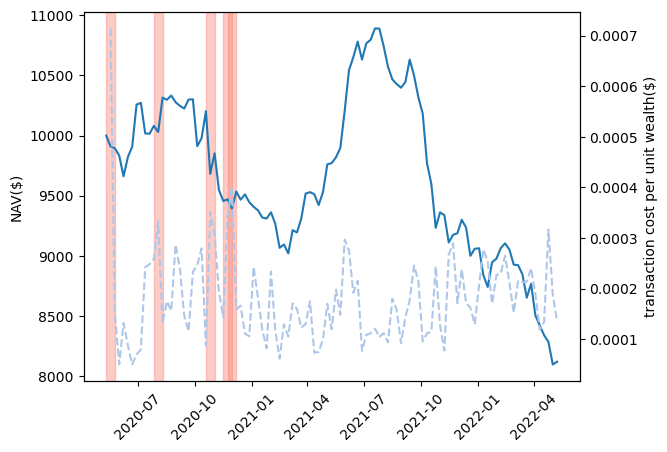

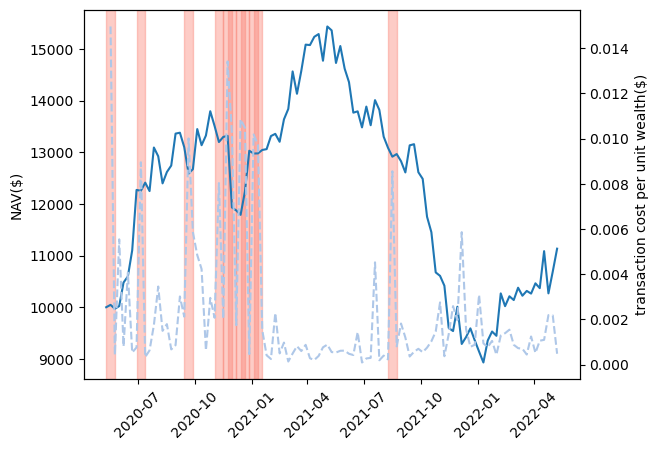

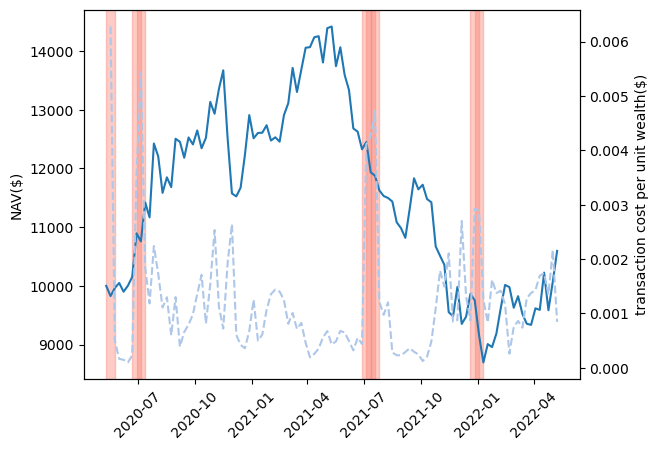

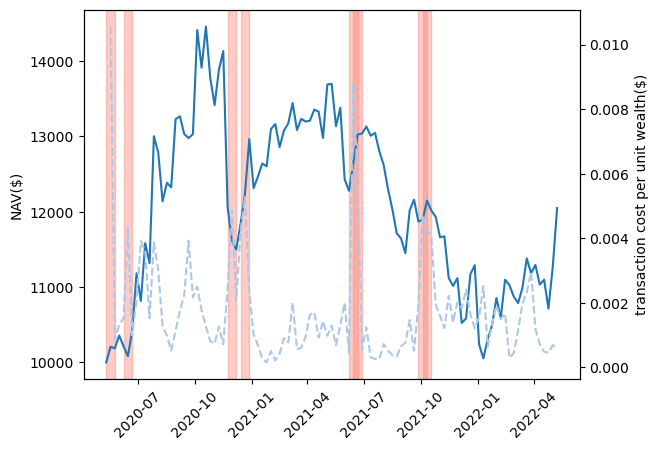

In [9]:
plt.style.use('default')
for name in res_cost.columns:
    fig, ax1 = plt.subplots()
    ax1.plot(t, df[name], '#1f77b4')
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_ylabel('NAV($)')

    #identify abnormal cost hike
    print(name, np.mean(res_cost[name]))
    a = t[1:][res_cost[name] > np.mean(res_cost[name]) + 1.5 * np.std(res_cost[name])]
    for d in range(0, len(a)):
        ind = t.get_loc(a.date[d].strftime('%Y-%m-%d'))
        ax1.axvspan(t[ind-1], t[ind+1], color='salmon', alpha=0.4)
    ax2 = ax1.twinx()
    ax2.set_ylabel('transaction cost per unit wealth($)')
    ax2.plot(t[1:], res_cost[name], '--', color='#aec7e8')

In [11]:
t.get_loc(a.date[1].strftime('%Y-%m-%d'))
len(a)

7